# Grover's Quantum Search Algorithm Tests

This Python notebook provides some practical tests and visualizations of the Grover Search algorithm. All tests have been executed on the **OpenQASM Simulator** (https://sooluthomas.github.io/testTranslation/terra/executing_quantum_programs.html#executing-quantum-programs) offered by **Qiskit** (https://qiskit.org/), but any other backend (simulator or real quantum machine) can be used to run these tests.

Have in mind that this test will use circuits used for the specific implementation of Grover Adaptive Search, and is therefore dependent on the concrete implementation of binary cost function and clause circuits. The main goal of these tests is not to showcase such implementation, but to demonstrate how the number of Grover iterate applications affect the algorithm's success probability.

In [1]:
from qiskit import *
from qiskit.visualization import plot_histogram

from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np

from random import getrandbits, randint

from binary_cost_function import *
from custom_gas import *
from num_base_converter import *

### Tested function:

The function we will test will be the following binary cost function:

$$
-1 \cdot \left[\mathtt{11111111}\right],
$$

where $\mathtt{X}, \mathtt{0}$ and $\mathtt{1}$ denote free, 0 and 1 required bit values, respectively. That is, the cost function is:

$$
\mathcal{C}(x) = -x_1x_2x_3x_4x_5x_6x_7x_8.
$$

More different clauses with no free bits can be added as desired. The chosen implementations of the operators that compose the Grover iterator $G$, which recall are:
  - the preparator $A$,
  - the oracle $O$ and
  - the diffusor $D$

will sepparate the strings that evaluate to $-1$ and $0$, meaning that this binary cost function is a valid example to test how the Grover Algorithm works. 

In [2]:
bcf_test = BinaryCostFunction(8)

clauses = [
    BinaryClause("11111111")
]

values = [-1]

for clause, value in zip(clauses, values):
    bcf_test.add_clause(clause, value)
    
print(bcf_test)

-1 * 11111111



We will choose the same number of qubits as in Grover Adaptive Search. This is not relevant for these tests, but to better understand the reason behind these choices, refer to the `GAS_Tester.ipynb` notebook.

In [3]:
bcf = bcf_test
n = bcf.num_bits
m = math.ceil(math.log(max([sum(filter(lambda x: x>0, values)) + 1, -sum(filter(lambda x: x<0, values))]), 2)) + 2

print("n = ", n, ", m = ", m, sep = "")
print("bcf: ")
print(bcf)

n = 8, m = 2
bcf: 
-1 * 11111111



The complete Grover Search circuit, which will be run iteratively with varying values of `threshold` and number of iteraitons `r`.

The `threshold` is implemented by adding an additional clause with bits $\left[\mathtt{X \dots X}\right]$ and value $-y$ where $y$ is the `threshold` for the current iteration.

This example shows the circuit with $y = 4$, $r = 3$.

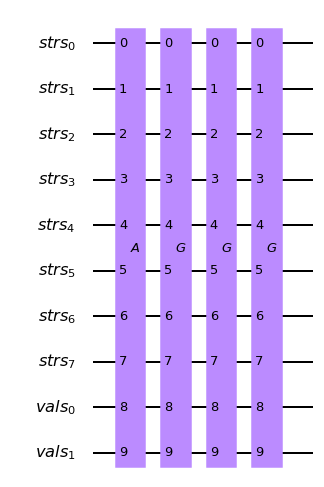

In [4]:
GAS_circuit(m, bcf, 4, 3).draw(output = "mpl")

### Test run:

We now perform a test run of Grover Search with the aforementioned function, which has $2^{8} = 256$ possible options to try out and only one of them correct, meaning the number of times the iterator $G$ must be applied is:

$$
r = \left \lfloor \frac{\pi}{4} \frac{1}{\arcsin{\left(\sqrt{\frac{1}{2^{8}}}\right)}} \right \rfloor = 12.
$$

In [5]:
r = 12

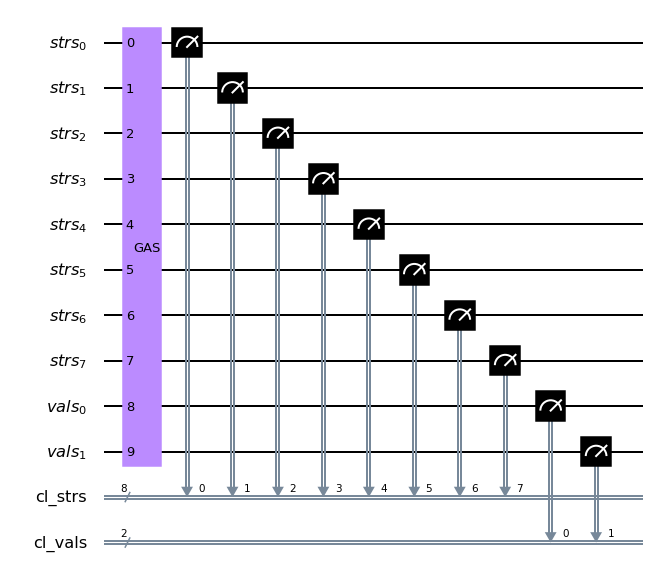

In [6]:
qc = QuantumCircuit()

qr_strs = QuantumRegister(n, "strs")
qr_vals = QuantumRegister(m, "vals")
cr_strs = ClassicalRegister(n, "cl_strs")
cr_vals = ClassicalRegister(m, "cl_vals")
qc.add_register(qr_strs)
qc.add_register(qr_vals)
qc.add_register(cr_strs)
qc.add_register(cr_vals)

GAS_gate = GAS_circuit(m, bcf, 0, r).to_gate(label = "GAS")
qc.append(GAS_gate, qr_strs[0:n] + qr_vals[0:m])

qc.measure(qr_strs, cr_strs)
qc.measure(qr_vals, cr_vals)

qc.draw(output = "mpl")

Run the next cells to execute the test.

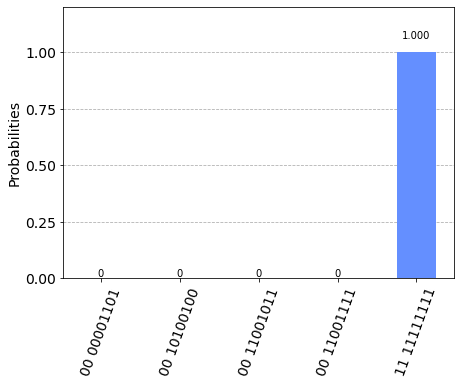

In [7]:
num_shots = 100000
job = execute(qc, Aer.get_backend("qasm_simulator"), shots = num_shots)
counts = job.result().get_counts()
plot_histogram(counts)

We can appreciate that the returned answer is almost surely the optimum string $\mathtt{11111111}$ and optimum value $-1$ with only $12$ applications of the iterator $G$. A classical computer would have to evaluate the cost function an average of $2^{n-1} = 128$ times to find the optimum string. Also, as $n$ grows, the probability of reading the correct answer also increases.

### Probability analysis:

One will see that if we choose values of `r` other than the optimal value and then re-run the test, the probability of obtaining a better answer will decrease. Here we test $r \in [1, 30]$. We will run the tests on a $6$-bit clause instead of $8$ to lower execution time, as simulation time increases exponentially with the number of qubits used.

In [8]:
bcf_test_2 = BinaryCostFunction(6)

clauses = [
    BinaryClause("1" * 6)
]

values = [-1]

for clause, value in zip(clauses, values):
    bcf_test_2.add_clause(clause, value)

In [9]:
bcf = bcf_test_2
n = bcf.num_bits
m = math.ceil(math.log(max([sum(filter(lambda x: x>0, values)) + 1, -sum(filter(lambda x: x<0, values))]), 2)) + 2
r_min = 1
r_max = 30

print("n = ", n, ", m = ", m, sep = "")
print("r = {0:d}, ..., {1:d}".format(r_min, r_max))
print("bcf: ")
print(bcf)

n = 6, m = 2
r = 1, ..., 30
bcf: 
-1 * 111111



Run the next cells to execute the test. <span style="color:red">**Warning:**</span> The test may take a few minutes to complete (approx. **5 mins**).

In [10]:
num_shots = 100000

r_vals = list(range(r_min, r_max+1))
percs = []
for r in r_vals:
    qc = QuantumCircuit()

    qr_strs = QuantumRegister(n, "strs")
    qr_vals = QuantumRegister(m, "vals")
    cr_strs = ClassicalRegister(n, "cl_strs")
    cr_vals = ClassicalRegister(m, "cl_vals")
    qc.add_register(qr_strs)
    qc.add_register(qr_vals)
    qc.add_register(cr_strs)
    qc.add_register(cr_vals)

    GAS_gate = GAS_circuit(m, bcf, 0, r).to_gate(label = "GAS")
    qc.append(GAS_gate, qr_strs[0:n] + qr_vals[0:m])

    qc.measure(qr_strs, cr_strs)
    qc.measure(qr_vals, cr_vals)

    qc.draw(output = "mpl")
    
    print("Running with r = {0:2d}... ".format(r), end = "")
    
    job = execute(qc, Aer.get_backend("qasm_simulator"), shots = num_shots)
    counts = job.result().get_counts()
    success_prob = counts.get("11 111111", 0)
    success_perc = 100*round(success_prob/num_shots, 4)
    percs.append(success_perc)
    
    print("Success probability: {0:2.2f}%".format(success_perc))

Running with r =  1... Success probability: 13.59%
Running with r =  2... Success probability: 34.44%
Running with r =  3... Success probability: 59.16%
Running with r =  4... Success probability: 81.64%
Running with r =  5... Success probability: 96.38%
Running with r =  6... Success probability: 99.65%
Running with r =  7... Success probability: 90.75%
Running with r =  8... Success probability: 71.70%
Running with r =  9... Success probability: 47.46%
Running with r = 10... Success probability: 23.71%
Running with r = 11... Success probability: 6.41%
Running with r = 12... Success probability: 0.01%
Running with r = 13... Success probability: 5.63%
Running with r = 14... Success probability: 22.33%
Running with r = 15... Success probability: 46.02%
Running with r = 16... Success probability: 70.16%
Running with r = 17... Success probability: 89.76%
Running with r = 18... Success probability: 99.46%
Running with r = 19... Success probability: 96.99%
Running with r = 20... Success pro

On the following graph we can appreciate the sinusoidal nature of the success probability of the algorithm.

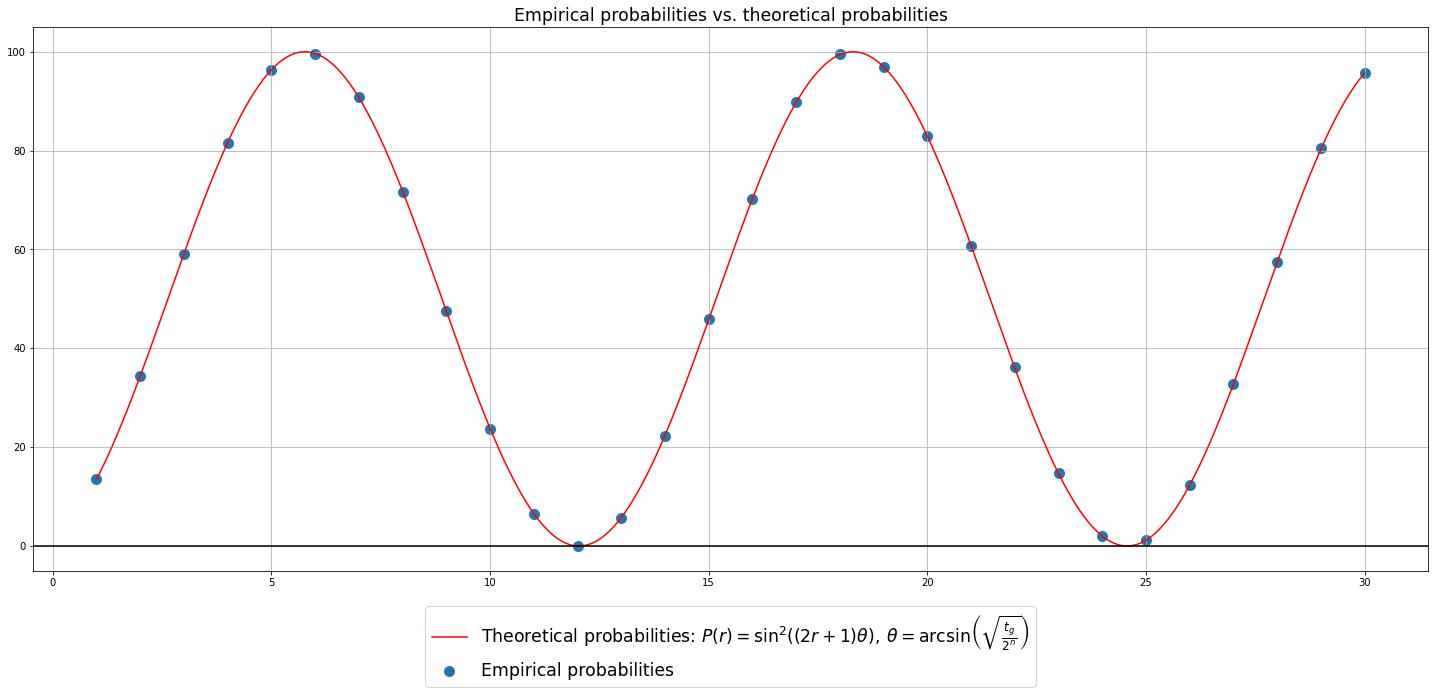

In [11]:
fig = plt.figure(figsize=(25,10))
ax = plt.subplot(1, 1, 1)
ax.scatter(r_vals, percs, linewidth = 5, label = "Empirical probabilities")
theta = math.asin(2**(-n/2))
x = np.linspace(r_min, r_max, (r_max - r_min) * 20)
ax.plot(x, 100*(np.sin(theta*((2*x)+1))**2), 'r', label = "Theoretical probabilities: " + r'$P(r) = \sin^2{((2r + 1)\theta)},\: \theta = \arcsin{\left(\sqrt{\frac{t_g}{2^n}}\right)}$')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fontsize = "xx-large")
ax.set_title("Empirical probabilities vs. theoretical probabilities", fontsize = "xx-large")
ax.grid()
ax.axhline(color = "black")
plt.show()

The tests can be performed with any cost function that has any number of optimal and possible string values by choosing the adequate parameters. As $n$ grows, the times a classical function will have to evaluate the cost function grows in order $O(2^n)$, while the number of applications of the iterator $G$ grows in order $O(2^{\frac{n}{2}})$.